# Обобщенная регрессия

## Библиотеки

In [2]:
import numpy as np
import scipy.stats as st
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

import statsmodels.api as sm
from sklearn.metrics import  auc,  accuracy_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Число визитов к доктору
**Cameron C. A., Trivedi P. K. Regression Analysis of Count Data. Cambridge University Press, 2013.**

Изучается функционирование системы здравоохранения Австралии. Для 1500 одиноких совершеннолетних граждан известны значения следующих показателей:

* социоэкономические:
    * пол
    * возраст, лет;
    * годовой доход, 10 тыс. долл.;
* индикаторы наличия страховки различных типов: 
    * частной, государственной для малоимущих, государственной для пожилых, инвалидов и ветеранов;
* краткосрочные характеристики здоровья:
    * число визитов к доктору за последние две недели;
    * число заболеваний за последние две недели;
    * число дней сниженной активности в связи с заболеванием или травмой за последние две недели;
* долгосрочные характеристики здоровья:
    * оценка состояния здоровья по опроснику Голдберга;
    * индикаторы наличия хронических заболеваний, ограничивающих и не ограничивающих активность.

Требуется построить модель числа визитов к доктору в зависимости от остальных признаков.

In [3]:
data = pd.read_csv('data/dvi.txt', delimiter=' ')
data.sample(5)

,SEX,AGE,INCOME,LEVYPLUS,FREEPOOR,FREEREPA,ILLNESS,ACTDAYS,HSCORE,CHCOND1,CHCOND2,DVISITS
657,m,22.000000,0.06,0,0,0,2,0,1,0,0,2
644,m,31.999999,0.25,1,0,0,2,14,1,0,1,1
67,f,72.000003,0.65,1,0,0,5,0,3,1,0,0
559,m,19.000000,0.06,0,0,0,2,0,12,0,0,1
975,f,72.000003,0.35,0,0,1,0,0,0,0,1,0


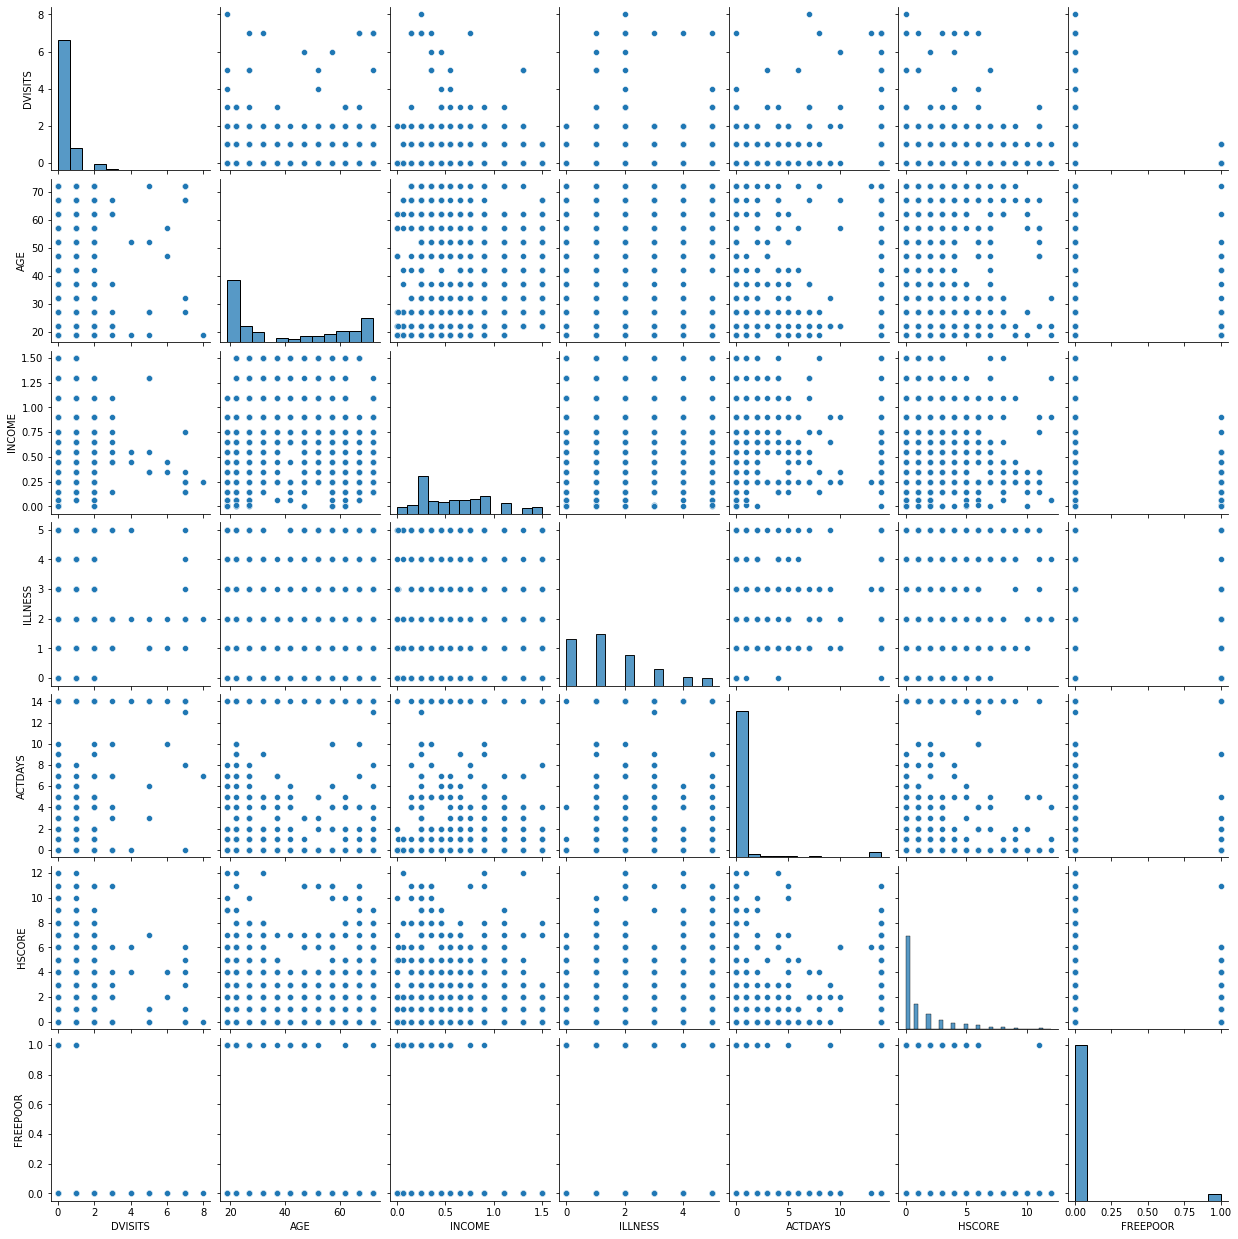

In [4]:
_ = sns.pairplot(data[['DVISITS', 'AGE', 'INCOME', 'ILLNESS', 'ACTDAYS', 'HSCORE', 'FREEPOOR']])

In [5]:
data['FREEPOOR'].sum()

59

Видим, что в выборке только 59 обладателей государственной страховки для малоимущих, причём только 2 из них когда-либо ходили к врачу. Коэффициент при таком признаке будет определяться неустойчиво. Исключим эти 59 наблюдений и признак.

In [6]:
data2 = data[data['FREEPOOR']==0]
data2.shape

(1441, 12)

Стандартная пуассоновская модель:

In [9]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+ILLNESS:ACTDAYS+SEX:ILLNESS', 
                             data=data2, family=sm.families.Poisson()).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
=================================================================
Model:                GLM              AIC:            1844.9395 
Link Function:        log              BIC:            -9249.0373
Dependent Variable:   DVISITS          Log-Likelihood: -915.47   
Date:                 2021-03-30 15:37 LL-Null:        -1143.8   
No. Observations:     1441             Deviance:       1180.6    
Df Model:             6                Pearson chi2:   1.85e+03  
Df Residuals:         1434             Scale:          1.0000    
Method:               IRLS                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Intercept        -1.6542   0.1375 -12.0285 0.0000 -1.9238 -1.3847
SEX[T.m]         -0.7593   0.1812  -4.1906 0.0000 -1.1144 -0.4042
ILLNESS           0.2737   0.0421   6.5038 0.0000  0.1912  0.3561
SEX[T.m]:ILLNESS  0.1953   0.0649   3.0070 0.0026  0.0680  0.3226
ACTDAYS           0.2069   0.0147  14.0609 0.0000  0.1781  0.2357
INCOME           -0.3140   0.1412  -2.2236 0.0262 -0.5908 -0.0372
ILLNESS:ACTDAYS  -0.0226   0.0057  -4.0029 0.0001 -0.0337 -0.0116
=================================================================

"""

Показатель overdispersion/underdispersion:  ```chi2 / Df Residuals```

Отрицательная биномиальная модель:

In [8]:
model = sm.GLM.from_formula('DVISITS~SEX+AGE+INCOME+LEVYPLUS+FREEREPA+ILLNESS+ACTDAYS+HSCORE+CHCOND1+CHCOND2',
                            data=data2, family=sm.families.NegativeBinomial()).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
===============================================================
Model:              GLM              AIC:            1785.5341 
Link Function:      log              BIC:            -9564.3663
Dependent Variable: DVISITS          Log-Likelihood: -881.77   
Date:               2021-03-30 15:34 LL-Null:        -1037.6   
No. Observations:   1441             Deviance:       836.16    
Df Model:           10               Pearson chi2:   1.40e+03  
Df Residuals:       1430             Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
----------------------------------------------------------------
Intercept   -1.9233    0.2244  -8.5722  0.0000  -2.3630  -1.4835
SEX[T.m]    -0.3677    0.1297  -2.8362  0.0046  -0.6218  -0.1136
AGE          0.0043    0.0039   1.0880  0.2766  -0.0034   0.0120
INCOME      -0.3401    0.1917  -1.7745  0.0760  -0.7158   0.0356
LEVYPLUS    -0.0109    0.1595  -0.0682  0.9456  -0.3236   0.3018
FREEREPA    -0.1976    0.2220  -0.8901  0.3734  -0.6327   0.2375
ILLNESS      0.2903    0.0449   6.4710  0.0000   0.2024   0.3782
ACTDAYS      0.1709    0.0135  12.6914  0.0000   0.1445   0.1972
HSCORE       0.0354    0.0258   1.3715  0.1702  -0.0152   0.0861
CHCOND1      0.0333    0.1473   0.2261  0.8211  -0.2554   0.3220
CHCOND2      0.1296    0.1961   0.6609  0.5087  -0.2547   0.5139
===============================================================

"""

Удалим незначимые признаки:

In [10]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS',
                            data=data2, family=sm.families.NegativeBinomial()).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
===============================================================
Model:              GLM              AIC:            1779.3163 
Link Function:      log              BIC:            -9607.4957
Dependent Variable: DVISITS          Log-Likelihood: -885.66   
Date:               2021-03-30 15:42 LL-Null:        -1037.6   
No. Observations:   1441             Deviance:       843.94    
Df Model:           3                Pearson chi2:   1.44e+03  
Df Residuals:       1437             Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
            Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
----------------------------------------------------------------
Intercept  -1.9482    0.1158  -16.8217  0.0000  -2.1752  -1.7212
SEX[T.m]   -0.4275    0.1231   -3.4734  0.0005  -0.6688  -0.1863
ILLNESS     0.3293    0.0389    8.4599  0.0000   0.2530   0.4056
ACTDAYS     0.1770    0.0128   13.8316  0.0000   0.1519   0.2020
===============================================================

"""

Попробуем возвращать по одному удалённые признаки:

In [11]:
formula = 'DVISITS~SEX+ILLNESS+ACTDAYS+'
for p in ['AGE','INCOME','LEVYPLUS','FREEREPA','HSCORE','CHCOND1','CHCOND2']:
    model = sm.GLM.from_formula(formula+p, data=data2, family=sm.families.NegativeBinomial()).fit()
    print (p, model.bic)

AGE -9601.95798792102
INCOME -9604.156703389735
LEVYPLUS -9600.22267074508
FREEREPA -9600.38972029986
HSCORE -9602.253492466227
CHCOND1 -9600.22262182329
CHCOND2 -9600.881835865213


Лучше всего модель, в которую возвращён доход:

In [13]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME',
                            data=data2, family=sm.families.NegativeBinomial()).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
===============================================================
Model:              GLM              AIC:            1777.3822 
Link Function:      log              BIC:            -9604.1567
Dependent Variable: DVISITS          Log-Likelihood: -883.69   
Date:               2021-03-30 15:48 LL-Null:        -1037.6   
No. Observations:   1441             Deviance:       840.00    
Df Model:           4                Pearson chi2:   1.41e+03  
Df Residuals:       1436             Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
            Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
----------------------------------------------------------------
Intercept  -1.7671    0.1475  -11.9769  0.0000  -2.0563  -1.4779
SEX[T.m]   -0.3679    0.1264   -2.9115  0.0036  -0.6156  -0.1203
ILLNESS     0.3206    0.0393    8.1640  0.0000   0.2436   0.3976
ACTDAYS     0.1770    0.0128   13.8441  0.0000   0.1520   0.2021
INCOME     -0.3426    0.1745   -1.9637  0.0496  -0.6846  -0.0006
===============================================================

"""

Ещё раз попробуем возвращать по одному удалённые признаки:

In [14]:
formula = 'DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+'
for p in ['AGE','LEVYPLUS','FREEREPA','HSCORE','CHCOND1','CHCOND2']:
    model = sm.GLM.from_formula(formula+p, data=data2, family=sm.families.NegativeBinomial()).fit()
    print (p, model.bic)

AGE -9597.428967802289
LEVYPLUS -9597.239497446899
FREEREPA -9597.069535608369
HSCORE -9598.710746537603
CHCOND1 -9596.885074625992
CHCOND2 -9597.261132485633


Попробуем добавлять значимые межфакторные взаимодействия:

In [15]:
formula = 'DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+'
features = ['SEX', 'ILLNESS', 'ACTDAYS', 'INCOME']
for f1 in range(len(features)):
    for f2 in range(f1+1, len(features)): 
        f1_ = features[f1]
        f2_ = features[f2]
        model = sm.GLM.from_formula(formula+str(f1_)+':'+str(f2_),
                                    data=data2, family=sm.families.NegativeBinomial()).fit()               
        for name, p in model.pvalues.items():
            if p<0.05 and ':' in name:
                print (f1_, f2_, model.bic)
                



SEX ILLNESS -9602.825793657119
ILLNESS ACTDAYS -9606.313252511018
ILLNESS INCOME -9601.963100280722


In [16]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+ILLNESS:ACTDAYS', data=data2, family=sm.families.NegativeBinomial()).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
================================================================
Model:               GLM              AIC:            1769.9526 
Link Function:       log              BIC:            -9606.3133
Dependent Variable:  DVISITS          Log-Likelihood: -878.98   
Date:                2021-03-30 15:49 LL-Null:        -1037.6   
No. Observations:    1441             Deviance:       830.57    
Df Model:            5                Pearson chi2:   1.40e+03  
Df Residuals:        1435             Scale:          1.0000    
Method:              IRLS                                       
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept       -1.8599   0.1533 -12.1294 0.0000 -2.1605 -1.5594
SEX[T.m]        -0.3420   0.1268  -2.6973 0.0070 -0.5905 -0.0935
ILLNESS          0.3691   0.0425   8.6815 0.0000  0.2858  0.4525
ACTDAYS          0.2449   0.0239  10.2350 0.0000  0.1980  0.2918
INCOME          -0.3677   0.1753  -2.0975 0.0359 -0.7113 -0.0241
ILLNESS:ACTDAYS -0.0323   0.0096  -3.3620 0.0008 -0.0511 -0.0134
================================================================

"""

In [17]:
model.wald_test('ILLNESS:ACTDAYS=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[11.30312164]], p-value=0.0007737688810791089, df_denom=1>

In [18]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+ILLNESS:ACTDAYS+SEX:ILLNESS', 
                            data=data2, family=sm.families.NegativeBinomial()).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
=================================================================
Model:                GLM              AIC:            1765.9476 
Link Function:        log              BIC:            -9605.0451
Dependent Variable:   DVISITS          Log-Likelihood: -875.97   
Date:                 2021-03-30 15:50 LL-Null:        -1037.6   
No. Observations:     1441             Deviance:       824.57    
Df Model:             6                Pearson chi2:   1.42e+03  
Df Residuals:         1434             Scale:          1.0000    
Method:               IRLS                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Intercept        -1.6985   0.1619 -10.4909 0.0000 -2.0158 -1.3812
SEX[T.m]         -0.7610   0.2148  -3.5431 0.0004 -1.1820 -0.3400
ILLNESS           0.2923   0.0514   5.6906 0.0000  0.1917  0.3930
SEX[T.m]:ILLNESS  0.2017   0.0820   2.4614 0.0138  0.0411  0.3624
ACTDAYS           0.2435   0.0240  10.1627 0.0000  0.1966  0.2905
INCOME           -0.3608   0.1754  -2.0571 0.0397 -0.7046 -0.0170
ILLNESS:ACTDAYS  -0.0321   0.0096  -3.3376 0.0008 -0.0509 -0.0132
=================================================================

"""

In [27]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+ILLNESS:ACTDAYS+SEX:ILLNESS+ILLNESS:INCOME', 
                            data=data2, family=sm.families.NegativeBinomial()).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
================================================================
Model:               GLM              AIC:            1765.7585 
Link Function:       log              BIC:            -9599.9611
Dependent Variable:  DVISITS          Log-Likelihood: -874.88   
Date:                2021-03-30 16:05 LL-Null:        -1037.6   
No. Observations:    1441             Deviance:       822.38    
Df Model:            7                Pearson chi2:   1.41e+03  
Df Residuals:        1433             Scale:          1.0000    
Method:              IRLS                                       
----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept        -1.5299   0.1949 -7.8493 0.0000 -1.9119 -1.1479
SEX[T.m]         -0.6928   0.2196 -3.1544 0.0016 -1.1232 -0.2623
ILLNESS           0.2118   0.0730  2.9007 0.0037  0.0687  0.3549
SEX[T.m]:ILLNESS  0.1690   0.0850  1.9883 0.0468  0.0024  0.3355
ACTDAYS           0.2422   0.0240 10.0919 0.0000  0.1952  0.2893
INCOME           -0.7209   0.3011 -2.3945 0.0166 -1.3109 -0.1308
ILLNESS:ACTDAYS  -0.0309   0.0096 -3.2123 0.0013 -0.0498 -0.0121
ILLNESS:INCOME    0.1773   0.1161  1.5271 0.1267 -0.0503  0.4049
================================================================

"""

**Последнее межфакторное взаимодействие можно занулить.**

In [28]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+ILLNESS:ACTDAYS+SEX:ILLNESS', 
                            data=data2, family=sm.families.NegativeBinomial()).fit()

Итоговая модель

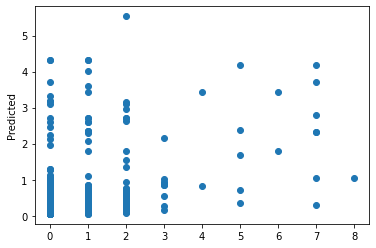

In [30]:
plt.scatter(data2['DVISITS'], model.predict(data2))
plt.ylabel('Predicted')
st.kendalltau(data2['DVISITS'], model.predict(data2))

plt.show()

Для сравнения — обычная линейная модель, не учитывающая счётную природу отклика:

In [31]:
model2 = sm.OLS.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+ILLNESS:ACTDAYS+SEX:ILLNESS', 
                             data=data2).fit()
model2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.242    
Dependent Variable: DVISITS          AIC:                3190.1662
Date:               2021-03-30 16:07 BIC:                3227.0779
No. Observations:   1441             Log-Likelihood:     -1588.1  
Df Model:           6                F-statistic:        77.79    
Df Residuals:       1434             Prob (F-statistic): 2.83e-84 
R-squared:          0.246            Scale:              0.53320  
------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
------------------------------------------------------------------
Intercept            0.1939   0.0499  3.8845 0.0001  0.0960 0.2919
SEX[T.m]            -0.0999   0.0573 -1.7422 0.0817 -0.2123 0.0126
ILLNESS              0.0835   0.0192  4.3541 0.0000  0.0459 0.1211
SEX[T.m]:ILLNESS     0.0047   0.0285  0.1645 0.8694 -0.0512 0.0605
ACTDAYS              0.1376   0.0137 10.0479 0.0000  0.1108 0.1645
INCOME              -0.1015   0.0534 -1.9007 0.0575 -0.2063 0.0033
ILLNESS:ACTDAYS     -0.0002   0.0055 -0.0351 0.9720 -0.0110 0.0107
------------------------------------------------------------------
Omnibus:            1102.829      Durbin-Watson:         2.009    
Prob(Omnibus):      0.000         Jarque-Bera (JB):      30709.545
Skew:               3.303         Prob(JB):              0.000    
Kurtosis:           24.630        Condition No.:         27       
==================================================================

"""

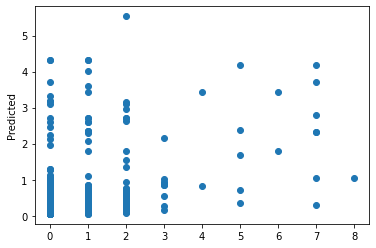

In [23]:
plt.scatter(data2['DVISITS'], model.predict(data2))
plt.ylabel('Predicted')
st.kendalltau(data2['DVISITS'], model.predict(data2))

plt.show()

### Финальная модель

In [24]:
model = sm.GLM.from_formula('DVISITS~SEX+ILLNESS+ACTDAYS+INCOME+ILLNESS:ACTDAYS+SEX:ILLNESS', 
                            data=data2, family=sm.families.NegativeBinomial()).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
=================================================================
Model:                GLM              AIC:            1765.9476 
Link Function:        log              BIC:            -9605.0451
Dependent Variable:   DVISITS          Log-Likelihood: -875.97   
Date:                 2021-03-30 16:00 LL-Null:        -1037.6   
No. Observations:     1441             Deviance:       824.57    
Df Model:             6                Pearson chi2:   1.42e+03  
Df Residuals:         1434             Scale:          1.0000    
Method:               IRLS                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Intercept        -1.6985   0.1619 -10.4909 0.0000 -2.0158 -1.3812
SEX[T.m]         -0.7610   0.2148  -3.5431 0.0004 -1.1820 -0.3400
ILLNESS           0.2923   0.0514   5.6906 0.0000  0.1917  0.3930
SEX[T.m]:ILLNESS  0.2017   0.0820   2.4614 0.0138  0.0411  0.3624
ACTDAYS           0.2435   0.0240  10.1627 0.0000  0.1966  0.2905
INCOME           -0.3608   0.1754  -2.0571 0.0397 -0.7046 -0.0170
ILLNESS:ACTDAYS  -0.0321   0.0096  -3.3376 0.0008 -0.0509 -0.0132
=================================================================

"""

Модель позволяет сделать следующие выводы:

* При прочих равных женщины обращаются к врачу в 2 раза чаще.
* Каждый день сниженной активности без болезни увеличивает число посещений врача в 1.2 раза.
* Каждая болезнь без снижения активности увеличивает число посещений врача в 1.3 раза у женщин и 1.6 у мужчин.
* При росте на единицу одновременно числа дней сниженной активности и числа заболеваний число визитов к доктору растёт в 1.03 медленнее, чем если бы эти признаки действовали независимо.
* Увеличение годового дохода на 10 тыс. долл. снижает среднее число визитов к врачу в 1.4 раза.



**Задача про регулировщика**: отправлять по дороге, где поедет больше машин в следующий промежуток времени. Значит нужно предсказать, сколько машин проедет в следующий момент времени — это пуассоновская СВ. Строим распределение и находим.

Второе решение — сводим к задаче бинарной классификации: куда повернуться регулировщику. Предсказываем бернулевскую СВ. Знаем, в какую сторону в каждом промежутке времени проехали больше. Теряем информацию о количестве проехавших машин. Свели к задаче лог регрессии.

## Риск остеопороза у женщин
**Global Longitudinal Study of Osteoporosis in Women (выборка по Hosmer D.W., Lemeshow S., Sturdivant R.X. Applied logistic regression. — Hoboken: John Wiley & Sons, 2013, 1.6.3.)**

Для 500 участниц исследования Global Longitudinal Study of Osteoporosis in Women (Center for Outcomes Research, the University of Massachusetts/Worcester) измерены следующие показатели:

* возраст, лет (не меньше 55);
* вес, кг;
* рост, см;
* ИМТ, кг/см2;
* бинарные признаки: курение, индикатор наступления менопаузы до 45 лет, индикатор необходимости помощи при подъёме из сидячего положения, перелом шейки бедра в прошлом (был/не было), перелом шейки бедра у матери (был/не было);
* самостоятельная субъективная оценка вероятности перелома (меньше/такая же/больше, чем у сверстниц).

Известно, у кого из участниц в первый год исследования произошёл перелом шейки бедра. Необходимо построить модель вероятности перелома с учётом имеющихся признаков.




In [34]:
data = pd.read_csv('data/GLOW500.txt', delimiter='\t')
data.sample(5)

,PRIORFRAC,AGE,WEIGHT,HEIGHT,BMI,PREMENO,MOMFRAC,ARMASSIST,SMOKE,RATERISK,FRACTURE
106,yes,67,61.2,153,26.14379,no,no,no,no,same,no
441,no,69,61.2,163,23.03436,no,no,no,no,less,yes
66,no,58,95.3,163,35.86887,no,yes,yes,no,less,no
337,yes,65,46.7,152,20.21295,no,no,no,yes,greater,no
252,yes,60,63.5,161,24.49751,yes,no,yes,no,greater,no


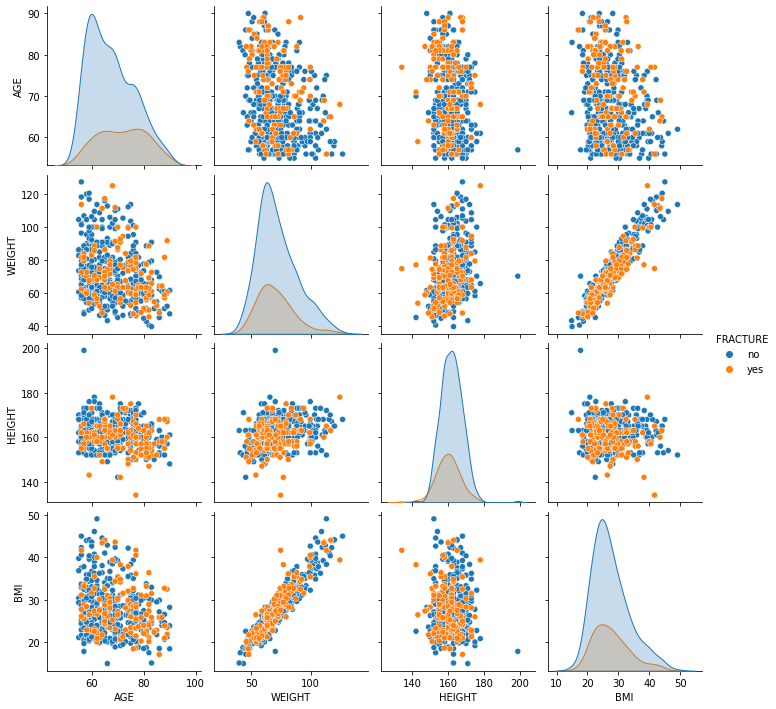

In [33]:
_ = sns.pairplot(data, hue='FRACTURE')

Проверим разделимость классов по категориальным предикторам:

In [35]:
predictors = ['SMOKE', 'PREMENO', 'ARMASSIST', 'PRIORFRAC', 'RATERISK']
for k in predictors:
    print (data.groupby([k, 'FRACTURE']).size(),'\n\n')

SMOKE  FRACTURE
no     no          347
       yes         118
yes    no           28
       yes           7
dtype: int64 


PREMENO  FRACTURE
no       no          303
         yes         100
yes      no           72
         yes          25
dtype: int64 


ARMASSIST  FRACTURE
no         no          250
           yes          62
yes        no          125
           yes          63
dtype: int64 


PRIORFRAC  FRACTURE
no         no          301
           yes          73
yes        no           74
           yes          52
dtype: int64 


RATERISK  FRACTURE
greater   no           98
          yes          49
less      no          139
          yes          28
same      no          138
          yes          48
dtype: int64 




Для предварительного отбора признаков построим одномерные модели по каждому фактору и оценим их значимость:

In [36]:
predictors = list(data.columns)
predictors.remove('FRACTURE')

for p in predictors:
    model = sm.GLM.from_formula('FRACTURE~'+str(p), data=data, family=sm.families.Binomial()).fit()
    print (model.summary2())

                       Results: Generalized linear model
Model:              GLM                               AIC:            544.0679  
Link Function:      logit                             BIC:            -2554.8069
Dependent Variable: ['FRACTURE[no]', 'FRACTURE[yes]'] Log-Likelihood: -270.03   
Date:               2021-03-30 16:19                  LL-Null:        -281.17   
No. Observations:   500                               Deviance:       540.07    
Df Model:           1                                 Pearson chi2:   500.      
Df Residuals:       498                               Scale:          1.0000    
Method:             IRLS                                                        
-----------------------------------------------------------------------------------
                      Coef.     Std.Err.       z       P>|z|      [0.025     0.975]
-----------------------------------------------------------------------------------
Intercept             1.4167      0.1305   

Многомерная модель со всеми значимыми предикторами (отсекали с $p-value$ > 0.2):

In [37]:
model = sm.GLM.from_formula('FRACTURE ~ AGE + HEIGHT + PRIORFRAC + MOMFRAC + ARMASSIST + RATERISK',
                            data=data, family=sm.families.Binomial()).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Generalized linear model
================================================================================
Model:              GLM                               AIC:            523.5004  
Link Function:      logit                             BIC:            -2550.0868
Dependent Variable: ['FRACTURE[no]', 'FRACTURE[yes]'] Log-Likelihood: -253.75   
Date:               2021-03-30 16:20                  LL-Null:        -281.17   
No. Observations:   500                               Deviance:       507.50    
Df Model:           7                                 Pearson chi2:   486.      
Df Residuals:       492                               Scale:          1.0000    
Method:             IRLS                                                        
-----------------------------------------------------------------------------------
                      Coef.     Std.Err.       z       P>|z|      [0.025     0.975]
-----------------------------------------------------------------------------------
Intercept            -3.4163      3.2068    -1.0653    0.2867    -9.7015     2.8690
PRIORFRAC[T.yes]     -0.6453      0.2461    -2.6224    0.0087    -1.1275    -0.1630
MOMFRAC[T.yes]       -0.6212      0.3070    -2.0237    0.0430    -1.2229    -0.0196
ARMASSIST[T.yes]     -0.4458      0.2328    -1.9148    0.0555    -0.9021     0.0105
RATERISK[T.less]      0.7069      0.2934     2.4092    0.0160     0.1318     1.2820
RATERISK[T.same]      0.2849      0.2611     1.0913    0.2751    -0.2268     0.7966
AGE                  -0.0343      0.0130    -2.6324    0.0085    -0.0599    -0.0088
HEIGHT                0.0438      0.0183     2.3999    0.0164     0.0080     0.0796
================================================================================

"""

Критерий Вальда считает модель существенно лучше константы:

In [39]:
model.wald_test('AGE=HEIGHT=PRIORFRAC[T.yes]=MOMFRAC[T.yes]=ARMASSIST[T.yes]=RATERISK[T.less]=RATERISK[T.same]=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[48.4671231]], p-value=2.8851048436501486e-08, df_denom=7>

Попробуем полностью или частично удалить RATERISK


In [40]:
model.wald_test('RATERISK[T.less]=RATERISK[T.same]=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[5.81992865]], p-value=0.0544776732311225, df_denom=2>

In [41]:
model.wald_test('RATERISK[T.less]=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[5.80438566]], p-value=0.01598625198426375, df_denom=1>

Оставим в модели RATERISKless — модель с ним значимо лучше, чем без него.

Попробуем возвращать в модель удалённые признаки:



In [42]:
def RATERISKless(x):
    return (x=='less')

model = sm.GLM.from_formula('FRACTURE ~ AGE + HEIGHT + PRIORFRAC + MOMFRAC + ARMASSIST +  RATERISKless(RATERISK)',
                            data=data, family=sm.families.Binomial()).fit()
model.summary2()




<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Generalized linear model
================================================================================
Model:              GLM                               AIC:            522.6898  
Link Function:      logit                             BIC:            -2555.1120
Dependent Variable: ['FRACTURE[no]', 'FRACTURE[yes]'] Log-Likelihood: -254.34   
Date:               2021-03-30 16:23                  LL-Null:        -281.17   
No. Observations:   500                               Deviance:       508.69    
Df Model:           6                                 Pearson chi2:   488.      
Df Residuals:       493                               Scale:          1.0000    
Method:             IRLS                                                        
--------------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                        -3.2251   3.2112 -1.0043 0.3152 -9.5190  3.0688
PRIORFRAC[T.yes]                 -0.6858   0.2428 -2.8249 0.0047 -1.1616 -0.2100
MOMFRAC[T.yes]                   -0.6393   0.3058 -2.0907 0.0366 -1.2385 -0.0400
ARMASSIST[T.yes]                 -0.4642   0.2317 -2.0033 0.0451 -0.9183 -0.0100
RATERISKless(RATERISK)[T.True]    0.5438   0.2542  2.1393 0.0324  0.0456  1.0420
AGE                              -0.0329   0.0130 -2.5371 0.0112 -0.0583 -0.0075
HEIGHT                            0.0431   0.0183  2.3577 0.0184  0.0073  0.0790
================================================================================

"""

In [43]:
print ('ORIGINAL', (model.llf))
formula = 'FRACTURE ~ AGE + HEIGHT + PRIORFRAC + MOMFRAC + ARMASSIST + RATERISKless(RATERISK)'
predictors2 = ['PRIORFRAC','WEIGHT', 'BMI', 'PREMENO', 'SMOKE']
for f in predictors2:
    formula2 =formula + '+' + f
    model2 = sm.GLM.from_formula(formula2,
                            data=data, family=sm.families.Binomial()).fit()
    print (f, model2.llf)

ORIGINAL -254.34490308054848
PRIORFRAC -254.34490308054848
WEIGHT -254.16550144631327
BMI -254.0708150176476
PREMENO -254.27057928005064
SMOKE -254.05697538025933


Проверим линейность логита по непрерывным признакам. Сглаженные диаграммы рассеяния: 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


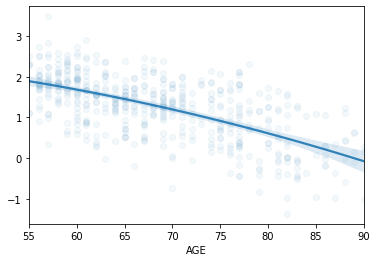

In [44]:
probs = model.predict(data)
odds = probs/(1-probs)
_ = sns.regplot(data['AGE'], np.log(odds), order=2, scatter=True,scatter_kws={'alpha':0.05},line_kws={'alpha':0.9})

Попробуем добавить к модели признак AGE ≥ 80:



In [45]:
model2 = sm.GLM.from_formula('FRACTURE ~ AGE + AGE>=80 + HEIGHT + PRIORFRAC + MOMFRAC + ARMASSIST + RATERISKless(RATERISK)',
                            data=data, family=sm.families.Binomial()).fit()
model2.summary2()



<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Generalized linear model
================================================================================
Model:              GLM                               AIC:            524.6797  
Link Function:      logit                             BIC:            -2548.9075
Dependent Variable: ['FRACTURE[no]', 'FRACTURE[yes]'] Log-Likelihood: -254.34   
Date:               2021-03-30 16:24                  LL-Null:        -281.17   
No. Observations:   500                               Deviance:       508.68    
Df Model:           7                                 Pearson chi2:   488.      
Df Residuals:       492                               Scale:          1.0000    
Method:             IRLS                                                        
--------------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                        -3.1775   3.2457 -0.9790 0.3276 -9.5389  3.1839
AGE >= 80[T.True]                 0.0406   0.4041  0.1005 0.9200 -0.7513  0.8325
PRIORFRAC[T.yes]                 -0.6861   0.2427 -2.8265 0.0047 -1.1619 -0.2103
MOMFRAC[T.yes]                   -0.6393   0.3057 -2.0910 0.0365 -1.2385 -0.0401
ARMASSIST[T.yes]                 -0.4639   0.2317 -2.0021 0.0453 -0.9180 -0.0098
RATERISKless(RATERISK)[T.True]    0.5446   0.2543  2.1415 0.0322  0.0462  1.0430
AGE                              -0.0341   0.0179 -1.9049 0.0568 -0.0692  0.0010
HEIGHT                            0.0433   0.0184  2.3548 0.0185  0.0073  0.0794
================================================================================

"""

Ничего лучше линейной модели подобрать не удалось.

Рассмотрим теперь все модели, в которые добавлено одно межфакторное взаимодействие:

In [46]:
formula = 'FRACTURE ~ AGE + HEIGHT + PRIORFRAC + MOMFRAC + ARMASSIST + RATERISKless(RATERISK)'
predictors = list(data.columns)
predictors.remove('FRACTURE')
for f1 in predictors:
    for f2 in predictors:
        formula2 =formula +'+{0}*{1}'.format(f1,f2)
        model2 = sm.GLM.from_formula(formula2,
                                data=data, family=sm.families.Binomial()).fit()
        for name, p in model2.pvalues.items():
            if p<0.05 and ':' in name:
                print (name,p)



PRIORFRAC[T.yes]:AGE 0.0230888919507213
PRIORFRAC[T.yes]:WEIGHT 0.02759162417404567
PRIORFRAC[T.yes]:BMI 0.023294339703386537
AGE:PRIORFRAC[T.yes] 0.0230888919507213
WEIGHT:PRIORFRAC[T.yes] 0.02759162417404567
HEIGHT:SMOKE[T.yes] 0.03813266575065955
BMI:PRIORFRAC[T.yes] 0.023294339703386537
MOMFRAC[T.yes]:ARMASSIST[T.yes] 0.03352507359760427
ARMASSIST[T.yes]:MOMFRAC[T.yes] 0.03352507359760427
SMOKE[T.yes]:HEIGHT 0.03813266575065955


Добавим все три межфакторных взаимодействия с p-value на уровне 0.025:

In [47]:
model3 = sm.GLM.from_formula("""FRACTURE ~ AGE + HEIGHT + PRIORFRAC + MOMFRAC + ARMASSIST + RATERISKless(RATERISK) +
                             +AGE:PRIORFRAC + MOMFRAC:ARMASSIST""",
                             data=data,  family=sm.families.Binomial()).fit()
model3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Generalized linear model
================================================================================
Model:              GLM                               AIC:            517.4194  
Link Function:      logit                             BIC:            -2551.9532
Dependent Variable: ['FRACTURE[no]', 'FRACTURE[yes]'] Log-Likelihood: -249.71   
Date:               2021-03-30 16:26                  LL-Null:        -281.17   
No. Observations:   500                               Deviance:       499.42    
Df Model:           8                                 Pearson chi2:   498.      
Df Residuals:       491                               Scale:          1.0000    
Method:             IRLS                                                        
--------------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                        -1.4774   3.3623 -0.4394 0.6604 -8.0673  5.1125
PRIORFRAC[T.yes]                 -4.6939   1.8779 -2.4996 0.0124 -8.3745 -1.0134
MOMFRAC[T.yes]                   -1.2146   0.3941 -3.0817 0.0021 -1.9871 -0.4421
ARMASSIST[T.yes]                 -0.6320   0.2524 -2.5040 0.0123 -1.1268 -0.1373
RATERISKless(RATERISK)[T.True]    0.5516   0.2565  2.1505 0.0315  0.0489  1.0543
MOMFRAC[T.yes]:ARMASSIST[T.yes]   1.2512   0.6215  2.0130 0.0441  0.0330  2.4693
AGE                              -0.0576   0.0166 -3.4610 0.0005 -0.0902 -0.0250
AGE:PRIORFRAC[T.yes]              0.0561   0.0259  2.1637 0.0305  0.0053  0.1069
HEIGHT                            0.0434   0.0185  2.3437 0.0191  0.0071  0.0797
================================================================================

"""

Получается значимо лучше.

Посмотрим графики качества классификации: 

In [48]:
tp, tn = [],[]
fp, fn = [], []
labels = (data['FRACTURE']=='no')*1.0
probas = model3.predict(data)
thresholds = np.arange(0,1.0,0.05)
for t in thresholds:
    tp_ = (probas[labels==1]>=t)
    tn_ = (probas[labels==0]<t)
    fp_ = (probas[labels==0]>=t)
    fn_ = (probas[labels==1]<t)
    
    tp.append(tp_)
    tn.append(tn_)
    fp.append(fp_)
    fn.append(fn_)

0.7225493333333335


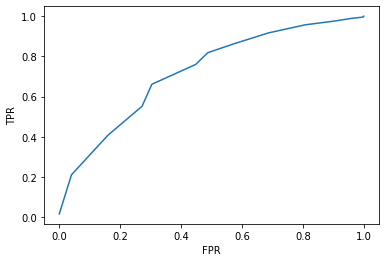

In [49]:
plt.plot(list(map(np.mean, fp)), list(map(np.mean, tp)))
plt.xlabel('FPR')
plt.ylabel('TPR')
print(auc(list(map(np.mean, fp)), list(map(np.mean, tp))))

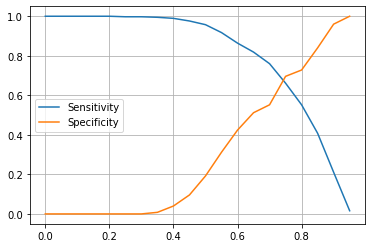

In [50]:
plt.plot(thresholds, list(map(np.mean, tp)),  label='Sensitivity')
plt.plot(thresholds, list(map(np.mean, tn)), label='Specificity')
plt.legend(loc='best')

plt.grid()
plt.show()

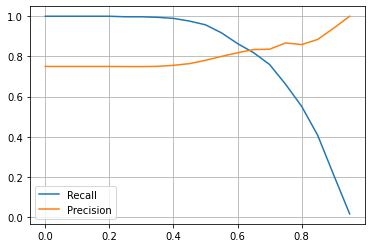

In [53]:
plt.plot(thresholds,  [tp_.sum()/(tp_.sum()+fn_.sum()) for tp_, fn_ in zip(tp, fn)], label='Recall')

prec = [tp_.sum()/(tp_.sum()+fp_.sum()) for tp_, fp_ in zip(tp, fp)]
plt.plot(thresholds, prec, label='Precision')

plt.legend(loc='best')
plt.grid()
plt.show()

При пороге 0.75 построенная модель обеспечивает чувствительность 0.7 и специфичность 0.7; площадь под ROC-кривой составляет 0.72.`

Модель позволяет сделать следующие выводы:

* для женщин, с которыми уже случался перелом шейки бедра, риск нового перелома в течение года существенно выше (в 110);
* каждые десять лет относительный риск перелома шейки бедра у женщин, с которыми он ещё не происходил, возрастает в 1.8 раз; при этом для женщин, у которых уже был перелом, увеличение возраста не приносит дополнительного значимого увеличения риска перелома (мультипликативный прирост риска за 10 лет 1.01);
* при прочих равных для женщин маленького роста риск перелома выше — на каждые 10 сантиметров уменьшения роста приходится увеличение риска перелома в 1.5 раз;
* для женщин, у матерей которых не было перелома шейки бедра, неспособность самостоятельно вставать из сидячего положения связана с повышением риска перелома в 1.9 раз;
* для женщин, которые способны самостоятельно вставать из сидячего положения, наличие перелома у матери связано с повышением риска перелома в 3.3 раз;
* женщины, оценивающие вероятность своего перелома как низкую, действительно при прочих равных имеют шанс перелома ниже в 1.7 раз.